## Imports

In [2]:
pip install torchsummary

In [1]:
import os
import datetime
from tqdm.auto import tqdm
import numpy as np
from timeit import default_timer as timer
from typing import Tuple

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# add directory to path so we can import modules from src
import sys
sys.path.append("../src")

## AudioFile class

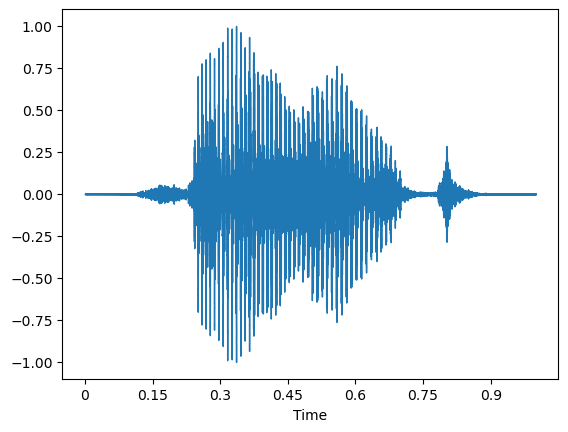

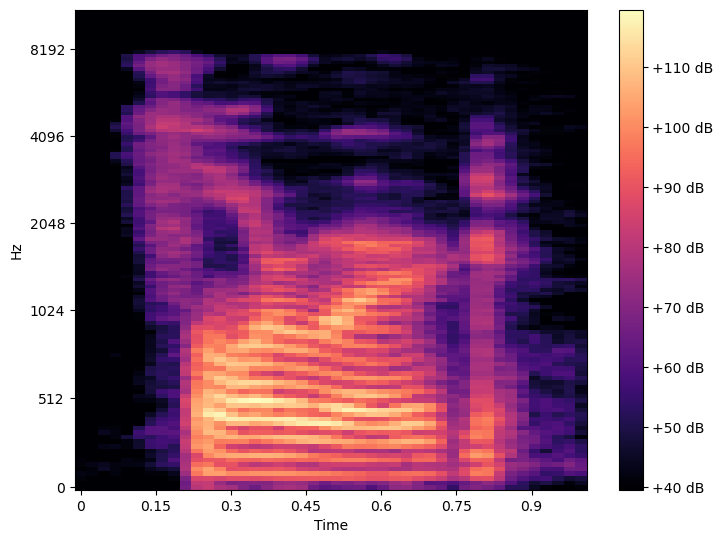

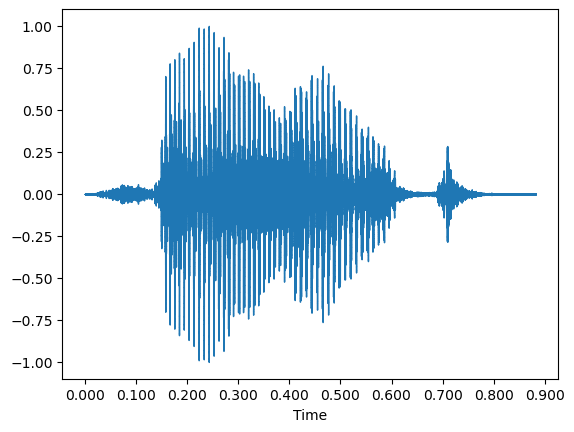

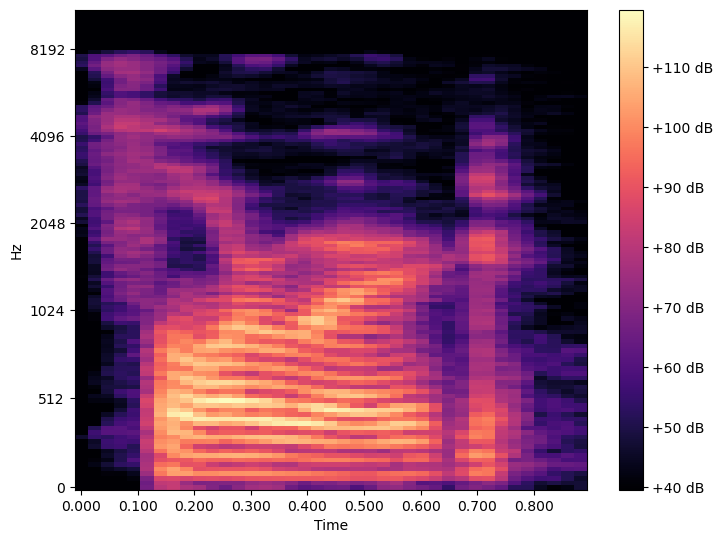

In [2]:
from team14.audio_file import AudioFile

_audio_file = '../data/audio/Speech Commands/forward/0a2b400e_nohash_0.wav'
test_audio = AudioFile(_audio_file)

test_audio.display_waveform()
test_audio.display_spectrogram()
test_audio.trim(top_db=50)
test_audio.play()
test_audio.display_waveform()
test_audio.display_spectrogram()
test_audio.play()

## Convert Audio Files to Spectrograms

 - set input_dir and output_dir accordingly
 - call process_directory()
 - if skip_existing is True, existing spectrogram PNG files will be skipped (recommended)


### NOTE:

- Only run this cell if you need to save out all the spectrograms. It takes awhile, and is prone to crashing (hence the use of skip_existing, so it can continue where it left off).
- Commented out the "process_directory(...)" line at the bottom to avoid accidental runs

In [3]:
def process_directory(input_dir, skip_existing=True, include_trimmed=False):
    output_dir = os.path.join("data", "images", os.path.basename(input_dir))
    output_dir_trimmed = os.path.join(output_dir + " (trimmed)")
    for root, dirs, files in os.walk(input_dir):
        # sort directories alphabetically
        dirs.sort()
        directory = os.path.basename(root)
        print(f"Processing directory: {directory}")
        for file in files:
            if file.endswith('.wav'):
                audio = None
                # trim off .wav from file
                base, _ = os.path.splitext(file)
                output_file = os.path.join(output_dir, directory, base + ".png")
                
                if not (skip_existing and os.path.exists(output_file)):
                    # load file
                    audio = AudioFile(os.path.join(root, file))
                    # save spectrogram
                    audio.save_spectrogram(output_dir, skip_existing=skip_existing)

                if include_trimmed:
                    output_file_trimmed = os.path.join(output_dir_trimmed, directory, base + ".png")
                    if not (skip_existing and os.path.exists(output_file_trimmed)):
                        # have we loaded the file already?
                        if not audio:
                            audio = AudioFile(os.path.join(root, file))
                        # trim and save
                        audio.trim()
                        audio.save_spectrogram(output_file_trimmed, skip_existing=skip_existing)
                
process_directory('data/audio/Speech Commands_noise', skip_existing=True, include_trimmed=False)

### Corrupt image check

In [4]:
from PIL import Image

# Define your directories
output_dir = os.path.join("data", "images", "Speech Commands")
output_dir_trimmed = os.path.join("data", "images", "Speech Commands (trimmed)")

def check_png_corruption(directories, output_file="corrupt_pngs.txt"):
    corrupt_files = []
    for directory in directories:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith('.png'):
                    file_path = os.path.join(root, file)
                    try:
                        with Image.open(file_path) as img:
                            img.verify()  # This will raise an exception if the file is corrupted.
                    except Exception as e:
                        print(f"Corrupted PNG found: {file_path} (Error: {e})")
                        corrupt_files.append(file_path)

    # Write the results to a text file
    if corrupt_files:
        with open(output_file, "w") as f:
            for filename in corrupt_files:
                f.write(f"{filename}\n")
        print(f"Found {len(corrupt_files)} corrupt PNG(s). Details saved to '{output_file}'.")
    else:
        print("No corrupt PNG files found.")

# List of directories to check
directories_to_check = [output_dir, output_dir_trimmed]

# Run the check
check_png_corruption(directories_to_check)

No corrupt PNG files found.


## Convolutional Neural Net

#### Setup and Parameters

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"  # Apple Metal Performance Shaders
else:
    device = "cpu"

print(f"Using {device} device")


datetime_stamp = datetime.datetime.now().strftime('%y%m%d-%H%M')

# setup tensorboard
writer_path = f"../logs/run_{datetime_stamp}"
writer = SummaryWriter(writer_path)

# path to save model
model_path = f"../models/cnn_ryan/{datetime_stamp}"
            

## PARAMETERS ##
image_size = (256, 190) # from 496x369. Closely maintains aspect ratio
num_channels = 3 # RGB images
# for DataLoader
batch_size = 64
num_workers = 2

Using cpu device


 #### Transform and Load data 

In [6]:
data_transforms = transforms.Compose([
    transforms.Resize((image_size[0], image_size[1])), # convert to square that can easily divide evenly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ImageFolder will load data from subdirectories and assign integer labels
data_dir = "../data/images/Speech Commands (trimmed)"
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# get class labels
class_labels = [label for label in dataset.class_to_idx]
num_classes = len(class_labels)
print(f"Classes: {num_classes}")

# for speed of training, we'll only use a subset of the data, randomly selected
fraction = 1
subset_size = int(len(dataset) * fraction)
indices = torch.randperm(len(dataset))[:subset_size]
dataset = torch.utils.data.Subset(dataset, indices)


# split into training and validation sets
val_split = 0.2
val_size = int(val_split * len(dataset))
train_size = len(dataset) - val_size

X_train, X_val = torch.utils.data.random_split(dataset, [train_size, val_size])
print(f"Training: {train_size}\nValidation: {val_size}")

# load batches
train_batches = torch.utils.data.DataLoader(
    X_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True)

val_batches = torch.utils.data.DataLoader(
    X_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True)

Classes: 36
Training: 84668
Validation: 21167


#### Helper Functions

In [7]:
def display_spectrogram(img):
    img = img / 2 + 0.5     # de-normalize
    plt.axis('off')
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

def display_spectrogram_batches(batches, writer_path=None):
    _iter = iter(batches)
    images, _ = next(_iter)
    img_grid = torchvision.utils.make_grid(images)
    display_spectrogram(img_grid)

    if writer_path:
        # write to tensorboard
        writer.add_images(writer_path, img_grid.unsqueeze(0))

def calc_convolution_output(image_size: Tuple[int, int], kernel_size, stride=1, padding=0):
    _w = int((image_size[0] - kernel_size[0] + 2 * padding) / stride) + 1
    _h = int((image_size[1] - kernel_size[1] + 2 * padding) / stride) + 1
    return (_w, _h)

def calc_pooling_output(image_size: Tuple[int, int], kernel_size, stride=None):
    if stride is None:
        stride = kernel_size
    _w = int((image_size[0] - kernel_size[0]) / stride[0]) + 1
    _h = int((image_size[1] - kernel_size[1]) / stride[1]) + 1
    return (_w, _h)

#### __Neural Net Model__


#### ResNet style

In [8]:
from team14.models.resnet_style import ResNet, BasicBlock, BottleneckBlock

# 19 layres, using BasicBlock
saved_model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

print(summary(saved_model, input_size=(num_channels, image_size[0], image_size[1])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 95]             864
       BatchNorm2d-2          [-1, 32, 128, 95]              64
              ReLU-3          [-1, 32, 128, 95]               0
         ConvLayer-4          [-1, 32, 128, 95]               0
            Conv2d-5          [-1, 64, 128, 95]          18,432
       BatchNorm2d-6          [-1, 64, 128, 95]             128
              ReLU-7          [-1, 64, 128, 95]               0
         ConvLayer-8          [-1, 64, 128, 95]               0
         MaxPool2d-9           [-1, 64, 64, 48]               0
           Conv2d-10           [-1, 64, 64, 48]          36,864
      BatchNorm2d-11           [-1, 64, 64, 48]             128
           Conv2d-12           [-1, 64, 64, 48]          36,864
      BatchNorm2d-13           [-1, 64, 64, 48]             128
       BasicBlock-14           [-1, 64,

#### Training

In [9]:
# display training time
def display_training_time(start, end):
    total_time = end - start
    print(f"Training time : {total_time:.3f} seconds")
    return total_time

# display training info for each epoch
def display_training_info(epoch, val_loss, train_loss, accuracy, learning_rate):
    accuracy = round(accuracy, 2)
    print(f"\nEpoch: {epoch} | Training loss: {train_loss.item():.3f} | Validation loss: {val_loss.item():.3f} | Accuracy: {accuracy:.2f}% | LR: {learning_rate:.4g}")
    
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# training
def train_neural_net(epochs, model, loss_func, optimizer, train_batches, val_batches, stop_patience=4, lr_scheduler=None):
    final_accuracy = 0
    last_val_accuracy = 0
    epochs_without_improvement = 0
            
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # === training ===
        model.train()
        with torch.enable_grad():
            train_loss = 0
            for images, labels in tqdm(train_batches, desc="Training Batches", leave=False):
                labels = labels.to(device)
                predictions = model(images.to(device))
                loss = loss_func(predictions, labels)
                train_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # update learning rate here if using OneCycleLR
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    lr_scheduler.step()

            train_loss /= len(train_batches)


        # === evaluation ===
        val_loss, val_accuracy = 0, 0
        model.eval()
        with torch.inference_mode():
            for images, labels in tqdm(val_batches, desc="Validation Batches", leave=False):
                labels = labels.to(device)
                predictions = model(images.to(device))
                val_loss += loss_func(predictions, labels)
                val_accuracy += accuracy_fn(y_true=labels, y_pred=predictions.argmax(dim=1))

            val_loss /= len(val_batches)
            val_accuracy /= len(val_batches)
            final_accuracy = val_accuracy


        # update learning rate here if using ReduceLROnPlateau
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(val_loss)

        # get current leqrning rate            
        learning_rate = optimizer.param_groups[0]['lr']

        display_training_info(epoch+1, val_loss, train_loss, val_accuracy, learning_rate)

        # log to tensorboard
        writer.add_scalars("Loss", {"Training": train_loss, "Validation": val_loss}, epoch)
        writer.add_scalar("Accuracy", val_accuracy, epoch)
        writer.add_scalar("Learning Rate", learning_rate, epoch)        

        # save model if validation accuracy improves
        if val_accuracy > last_val_accuracy:
            os.makedirs(model_path, exist_ok=True)
            torch.save(model.state_dict(), f"{model_path}/model_params.pt")
            torch.save(model, f"{model_path}/model_full.pt")
            print(f"Checkpoint saved at epoch {epoch+1} with val accuracy {val_accuracy:.2f}%")
            epochs_without_improvement = 0  # reset counter
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= stop_patience:
            print(f"Early stopping: no improvement in validation accuracy for {stop_patience} epochs.")
            break

        # update last_val_accuracy
        last_val_accuracy = val_accuracy
        
    return final_accuracy

In [ ]:
saved_model = saved_model.to(device)

max_epochs = 50
stop_patience = 5   # if no improvement in validation accuracy for this many epochs, stop training
learning_rate = 3e-3

# parameters for OneCycleLR
max_learning_rate = 1e-2
steps_per_epoch = len(train_batches)
total_steps = max_epochs * steps_per_epoch  # total number of training steps

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(saved_model.parameters(), lr=learning_rate)

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_learning_rate, total_steps=total_steps)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)


train_time_start_on_gpu = timer()
model_accuracy = train_neural_net(max_epochs, saved_model, loss_func, optimizer, train_batches, val_batches, stop_patience, lr_scheduler)
print(f"\nTraining complete : {model_accuracy} %")
display_training_time(start=train_time_start_on_gpu, end=timer())

writer.flush()
writer.close()

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/1323 [00:04<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 1 | Training loss: 0.945 | Validation loss: 0.437 | Accuracy: 86.78% | LR: 0.003
Checkpoint saved at epoch 1 with val accuracy 86.78%


Training Batches:   0%|          | 0/1323 [00:05<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:05<?, ?it/s]


Epoch: 2 | Training loss: 0.269 | Validation loss: 0.278 | Accuracy: 91.30% | LR: 0.003
Checkpoint saved at epoch 2 with val accuracy 91.30%


Training Batches:   0%|          | 0/1323 [00:05<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 3 | Training loss: 0.200 | Validation loss: 0.252 | Accuracy: 92.02% | LR: 0.003
Checkpoint saved at epoch 3 with val accuracy 92.02%


Training Batches:   0%|          | 0/1323 [00:05<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 4 | Training loss: 0.162 | Validation loss: 0.218 | Accuracy: 93.54% | LR: 0.003
Checkpoint saved at epoch 4 with val accuracy 93.54%


Training Batches:   0%|          | 0/1323 [00:04<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 5 | Training loss: 0.134 | Validation loss: 0.218 | Accuracy: 93.53% | LR: 0.003
No improvement for 1 epoch(s)


Training Batches:   0%|          | 0/1323 [00:05<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 6 | Training loss: 0.112 | Validation loss: 0.212 | Accuracy: 93.91% | LR: 0.003
Checkpoint saved at epoch 6 with val accuracy 93.91%


Training Batches:   0%|          | 0/1323 [00:06<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:13<?, ?it/s]


Epoch: 7 | Training loss: 0.093 | Validation loss: 0.188 | Accuracy: 94.52% | LR: 0.003
Checkpoint saved at epoch 7 with val accuracy 94.52%


Training Batches:   0%|          | 0/1323 [00:04<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:05<?, ?it/s]


Epoch: 8 | Training loss: 0.080 | Validation loss: 0.259 | Accuracy: 93.40% | LR: 0.003
No improvement for 1 epoch(s)


Training Batches:   0%|          | 0/1323 [00:05<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 9 | Training loss: 0.067 | Validation loss: 0.209 | Accuracy: 94.54% | LR: 0.003
Checkpoint saved at epoch 9 with val accuracy 94.54%


Training Batches:   0%|          | 0/1323 [00:04<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 10 | Training loss: 0.060 | Validation loss: 0.226 | Accuracy: 94.48% | LR: 0.003
No improvement for 1 epoch(s)


Training Batches:   0%|          | 0/1323 [00:04<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 11 | Training loss: 0.051 | Validation loss: 0.202 | Accuracy: 95.00% | LR: 0.0003
Checkpoint saved at epoch 11 with val accuracy 95.00%


Training Batches:   0%|          | 0/1323 [00:04<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 12 | Training loss: 0.022 | Validation loss: 0.170 | Accuracy: 95.94% | LR: 0.0003
Checkpoint saved at epoch 12 with val accuracy 95.94%


Training Batches:   0%|          | 0/1323 [00:04<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 13 | Training loss: 0.015 | Validation loss: 0.183 | Accuracy: 95.98% | LR: 0.0003
Checkpoint saved at epoch 13 with val accuracy 95.98%


Training Batches:   0%|          | 0/1323 [00:04<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:04<?, ?it/s]


Epoch: 14 | Training loss: 0.011 | Validation loss: 0.197 | Accuracy: 95.92% | LR: 0.0003
No improvement for 1 epoch(s)


Training Batches:   0%|          | 0/1323 [00:05<?, ?it/s]

Validation Batches:   0%|          | 0/331 [00:05<?, ?it/s]


Epoch: 15 | Training loss: 0.008 | Validation loss: 0.208 | Accuracy: 95.92% | LR: 0.0003
No improvement for 2 epoch(s)


Training Batches:   0%|          | 0/1323 [00:05<?, ?it/s]

## Inference and nnViewer

In [ ]:
from PIL import Image
from nnViewer import wrap_model, run_gui
from team14.models.resnet_style import ResNet


# load a torch model
saved_model = torch.load("../models/cnn_ryan/resnet-style/model_full.pt", weights_only=False)
# move to cpu as otherwise nnViewer won't work
device = 'cpu' 
saved_model.to(device)

# Wrap the model using nnViewer's wrap_model function
wrapped_model = wrap_model(saved_model)

# grab an image
img = Image.open("../data/images/Speech Commands/backward/0ba018fc_nohash_1.png").convert('RGB')

image_size = (256, 190) # from 496x369. Closely maintains aspect ratio
data_transforms = transforms.Compose([
    transforms.Resize((image_size[0], image_size[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
img = data_transforms(img).unsqueeze(0)  # [1, 3, 256, 190]

# do a forward pass on the image
saved_model.eval()  # Set the model to evaluation mode to disable dropout, etc.
with torch.no_grad():
    output = saved_model(img)

In [ ]:
# Launch the nnViwer GUI
run_gui(wrapped_model.graph)